In [ ]:
import netCDF4 as netcdf
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import igraph as ig
import networkx as nx
import pyunicorn
import seaborn as sn
import itertools
import pickle

from mpl_toolkits.basemap import shiftgrid
from mpl_toolkits.basemap import Basemap
from networkx.algorithms import community
from pyunicorn import climate
from scipy import optimize
from scipy.optimize import fsolve
from sklearn.linear_model import LinearRegression

# Dataset

In [ ]:
ds = xr.open_dataset('./data/sst.mnmean.nc')
ds

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2029)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0
    geospatial_laty_max:       89.0
    geospatial_laty_min:       -89.0
    geospatial_lat_max:        89.0
    geospatial_lat_min:        -89.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    cdm_data_type:             Grid
    project:                   NOAA Extended Reconstructed Sea Surface Temper...
    original_publisher_url:    http://www.ncdc.noaa.gov
    References:                https://www.ncdc.noaa.gov/data-access/marineoc...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    title:                     NOAA ERSSTv5 (in situ only)
    history:                   created 07/2017 by PSD data using NCEI's ERSST...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    citation:                  Huang et al, 2017: Extended Reconstructed Sea ...
    platform:                  Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    standard_name_vocabulary:  CF Standard Name Table (v40, 25 January 2017)
    processing_level:          NOAA Level 4
    Conventions:               CF-1.6, ACDD-1.3
    metadata_link:             :metadata_link = https://doi.org/10.7289/V5T72...
    creator_name:              Boyin Huang (original)
    date_created:              2017-06-30T12:18:00Z (original)
    product_version:           Version 5
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-02-04

In [ ]:
# filter using time
ds_filtered = ds.where( (ds['time.year'] < 2000) & (ds['time.year'] > 1980), drop=True)

In [ ]:
# save to new netCDF4
ds_filtered.to_netcdf('./data/sst.mon.mean.1980.2000.NOAA.v5.nc')

In [ ]:
ds_filtered

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 228)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1981-01-01 1981-02-01 ... 1999-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes:
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0
    geospatial_laty_max:       89.0
    geospatial_laty_min:       -89.0
    geospatial_lat_max:        89.0
    geospatial_lat_min:        -89.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    cdm_data_type:             Grid
    project:                   NOAA Extended Reconstructed Sea Surface Temper...
    original_publisher_url:    http://www.ncdc.noaa.gov
    References:                https://www.ncdc.noaa.gov/data-access/marineoc...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    title:                     NOAA ERSSTv5 (in situ only)
    history:                   created 07/2017 by PSD data using NCEI's ERSST...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    citation:                  Huang et al, 2017: Extended Reconstructed Sea ...
    platform:                  Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    standard_name_vocabulary:  CF Standard Name Table (v40, 25 January 2017)
    processing_level:          NOAA Level 4
    Conventions:               CF-1.6, ACDD-1.3
    metadata_link:             :metadata_link = https://doi.org/10.7289/V5T72...
    creator_name:              Boyin Huang (original)
    date_created:              2017-06-30T12:18:00Z (original)
    product_version:           Version 5
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-02-04

## Timeseries plot

In [ ]:
lon_value = 346
lat_value = 44

ds_lon = ds_filtered.where(ds_filtered.lon == lon_value, drop=True)
ds_lat = ds_lon.where(ds_lon.lat == lat_value, drop=True)

In [ ]:
sst = ds_lat.sst.values.reshape(-1)
time = ds_lat.time.values.reshape(-1)

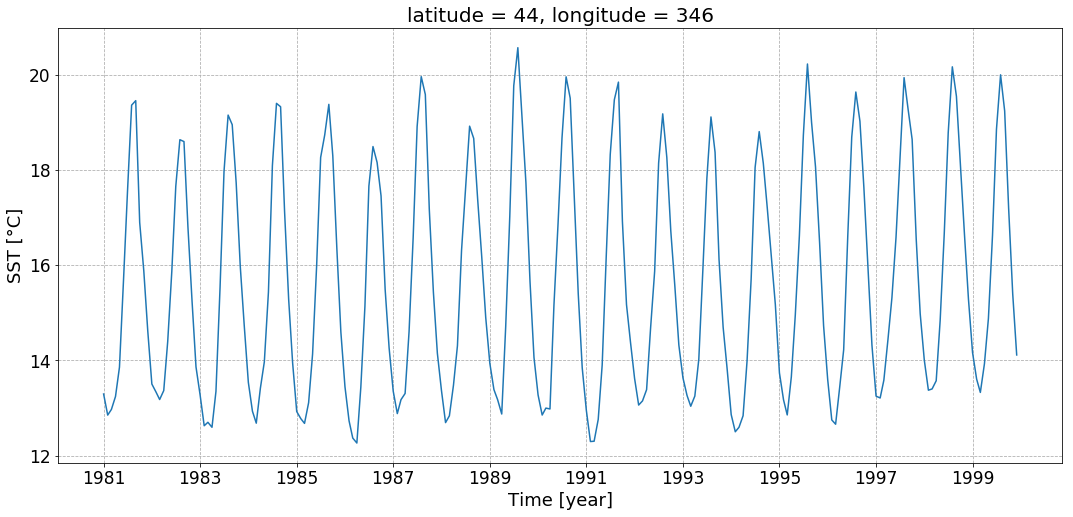

In [ ]:
fig, ax= plt.subplots(figsize=(18,8))
ax.plot(time, sst)


ax.tick_params(axis='both', which='major', labelsize=17)

ax.set_xlabel('Time [year]', fontsize=18)
ax.set_ylabel('SST [°C]', fontsize=18)
ax.set_title('latitude = {}, longitude = {}'.format(lat_value, lon_value), fontsize=20)
ax.grid(ls='--')
plt.savefig('./images/time_series.pdf', dpi=300, facecolor='white')
plt.show()



## NaN

In [ ]:
n_time_steps = ds_filtered.time.values.shape[0]
print('Number of time steps: ', n_time_steps)

n_grid_nan = np.sum(xr.ufuncs.isnan(ds_filtered).sum('time').sst.values == n_time_steps)
n_grid = ds_filtered.dims['lat']*ds_filtered.dims['lon']
n_grid_sea = n_grid-n_grid_nan

print('\nNumber of land point (NaN): ', n_grid_nan)
print('Number of sea point: ', n_grid_sea)
print('Total number of grid Point: ', n_grid)

Number of time steps:  228

Number of land point (NaN):  5032
Number of sea point:  10988
Total number of grid Point:  16020


## Import data

In [ ]:
DATA_FILENAME = "./data/sst.mon.mean.1980.2000.NOAA.v5.nc"

In [ ]:
#  Type of data file ("NetCDF" indicates a NetCDF file with data on a regular lat-lon grid)
FILE_TYPE = "NetCDF"

#  Indicate data source (optional)
DATA_SOURCE = "ncep_ncar_reanalysis"

#  Name of observable in NetCDF file
OBSERVABLE_NAME = "sst"

#  Select a subset in time and space from the data (e.g., a particular region
#  or a particular time window, or both)
WINDOW = {"time_min": 0., "time_max": 0., "lat_min": 20., "lon_min": 20.,
          "lat_max": 20., "lon_max": 20.}  # selects the whole data set

In [ ]:
#Indicate the length of the annual cycle in the data (e.g., 12 for monthly
#  data). This is used for calculating climatological anomaly values
#  correctly.
TIME_CYCLE = 12

#  Related to climate network construction

#  For setting fixed threshold
THRESHOLD = 0.5

#  Indicates whether to use only data from winter months (DJF) for calculating
#  correlations
WINTER_ONLY = False

In [ ]:
#  Create a ClimateData object containing the data and print information

data = climate.ClimateData.Load(
    file_name=DATA_FILENAME, observable_name=OBSERVABLE_NAME,
    data_source=DATA_SOURCE, file_type=FILE_TYPE,
    window=WINDOW, time_cycle=TIME_CYCLE)

#  Print some information on the data set
print(data)

Reading NetCDF File and converting data to NumPy array...
File format: NETCDF4
Global attributes:
climatology: Climatology is based on 1971-2000 SST, Xue, Y., T. M. Smith, and R. W. Reynolds, 2003: Interdecadal changes of 30-yr SST normals during 1871.2000. Journal of Climate, 16, 1601-1612.
description: In situ data: ICOADS2.5 before 2007 and NCEP in situ data from 2008 to present. Ice data: HadISST ice before 2010 and NCEP ice after 2010.
keywords_vocabulary: NASA Global Change Master Directory (GCMD) Science Keywords
keywords: Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature >
instrument: Conventional thermometers
source_comment: SSTs were observed by conventional thermometers in Buckets (insulated or un-insulated canvas and wooded buckets) or Engine Room Intaker
geospatial_lon_min: -1.0
geospatial_lon_max: 359.0
geospatial_laty_max: 89.0
geospatial_laty_min: -89.0
geospatial_lat_max: 89.0
geospatial_lat_min: -89.0
geospatial_lat_units: degrees_north
geospatial_l

/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/pyunicorn/core/data.py:284: RuntimeWarning: invalid value encountered in less
  observable = f.variables[observable_name][:].astype("float32")
/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/pyunicorn/core/data.py:284: RuntimeWarning: invalid value encountered in greater
  observable = f.variables[observable_name][:].astype("float32")


In [ ]:
# measurements = time_step*grid_points
n_time_steps*n_grid

3652560

In [ ]:
# data.observable() is a masked array with mask = True when the data is nan
data.observable()

masked_array(
  data=[[-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --],
        [-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --],
        [-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --],
        ...,
        [-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --],
        [-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --],
        [-1.7999999523162842, -1.7999999523162842, -1.7999999523162842,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=nan,
  dt

In [ ]:
# data.observable.data shape
data.observable().data.shape

(228, 16020)

In [ ]:
# define the corresponding indexes between the df_filtered and data.observable()
len_lat = len(ds_filtered.lat)
len_lon = len(ds_filtered.lon)
lat_indexes = np.zeros(n_grid)
lon_indexes = np.zeros(n_grid)

for i in range(len_lat):
    for j in range(len_lon):
        lat_indexes[i*len_lon+j]=i
        lon_indexes[i*len_lon+j]=j

In [ ]:
# list of indexes of nan point in grid

nan_indexes = np.arange(n_grid)[np.all(data.observable().mask, axis=0)]
sea_indexes = np.arange(n_grid)[np.all(~data.observable().mask, axis=0)]

print(len(nan_indexes)+len(sea_indexes))

16020


In [ ]:
# select an index between 0 and 90*180(=16200)
ind = np.random.randint(n_grid)
    
print('corresponding latitude: ',ds_filtered.lat.values[int(lat_indexes[ind])])
print('corresponding longitude: ',ds_filtered.lon.values[int(lon_indexes[ind])])

if ind in nan_indexes:
    print('This is not a sea point!')

np.allclose(ds_filtered.sst.values[:,int(lat_indexes[ind]), int(lon_indexes[ind])], 
            data.observable().data[:,ind], atol=1e-06, equal_nan=True)

# else:
#     print('\nSST time series from ds_filtered: \n\n', ds_filtered.sst.values[:,int(lat_indexes[ind]), int(lon_indexes[ind])])
#     print('\nSST time series from data.observable: \n\n', data.observable().data[:,ind])

corresponding latitude:  -66.0
corresponding longitude:  226.0


True

In [ ]:
# data.anomaly shape
data.anomaly().shape

Calculating daily (monthly) anomaly values...


(228, 16020)

In [ ]:
# it is evaluate subtracting to each point of the grid its own mean for that month, in fact

anomaly = np.zeros((n_time_steps,n_grid))

for i in range(TIME_CYCLE):
    sample = data.observable().data[i::TIME_CYCLE,:]
    anomaly[i::TIME_CYCLE,:] = sample - sample.mean(axis=0)
    
np.allclose(anomaly[:,ind], data.anomaly()[:,ind], atol=1e-06, equal_nan=True)

True

In [ ]:
zero_std_ind = np.arange(n_grid)[np.std(data.anomaly(), axis=0)==0]

In [ ]:
not_zero_sea_indexes = np.setdiff1d(sea_indexes, zero_std_ind)

In [ ]:
for ind in zero_std_ind:
    print('corresponding latitude: ',ds_filtered.lat.values[int(lat_indexes[ind])])
    print('corresponding longitude: ',ds_filtered.lon.values[int(lon_indexes[ind])], '\n')

corresponding latitude:  88.0
corresponding longitude:  0.0 

corresponding latitude:  88.0
corresponding longitude:  2.0 

corresponding latitude:  88.0
corresponding longitude:  4.0 

corresponding latitude:  88.0
corresponding longitude:  6.0 

corresponding latitude:  88.0
corresponding longitude:  8.0 

corresponding latitude:  88.0
corresponding longitude:  10.0 

corresponding latitude:  88.0
corresponding longitude:  12.0 

corresponding latitude:  88.0
corresponding longitude:  14.0 

corresponding latitude:  88.0
corresponding longitude:  16.0 

corresponding latitude:  88.0
corresponding longitude:  18.0 

corresponding latitude:  88.0
corresponding longitude:  20.0 

corresponding latitude:  88.0
corresponding longitude:  22.0 

corresponding latitude:  88.0
corresponding longitude:  24.0 

corresponding latitude:  88.0
corresponding longitude:  26.0 

corresponding latitude:  88.0
corresponding longitude:  28.0 

corresponding latitude:  88.0
corresponding longitude:  30.0

corresponding latitude:  86.0
corresponding longitude:  202.0 

corresponding latitude:  86.0
corresponding longitude:  204.0 

corresponding latitude:  86.0
corresponding longitude:  206.0 

corresponding latitude:  86.0
corresponding longitude:  208.0 

corresponding latitude:  86.0
corresponding longitude:  210.0 

corresponding latitude:  86.0
corresponding longitude:  212.0 

corresponding latitude:  86.0
corresponding longitude:  214.0 

corresponding latitude:  86.0
corresponding longitude:  216.0 

corresponding latitude:  86.0
corresponding longitude:  218.0 

corresponding latitude:  86.0
corresponding longitude:  220.0 

corresponding latitude:  86.0
corresponding longitude:  222.0 

corresponding latitude:  86.0
corresponding longitude:  224.0 

corresponding latitude:  86.0
corresponding longitude:  226.0 

corresponding latitude:  86.0
corresponding longitude:  228.0 

corresponding latitude:  86.0
corresponding longitude:  230.0 

corresponding latitude:  86.0
correspond


corresponding latitude:  82.0
corresponding longitude:  104.0 

corresponding latitude:  82.0
corresponding longitude:  106.0 

corresponding latitude:  82.0
corresponding longitude:  108.0 

corresponding latitude:  82.0
corresponding longitude:  110.0 

corresponding latitude:  82.0
corresponding longitude:  112.0 

corresponding latitude:  82.0
corresponding longitude:  114.0 

corresponding latitude:  82.0
corresponding longitude:  130.0 

corresponding latitude:  82.0
corresponding longitude:  132.0 

corresponding latitude:  82.0
corresponding longitude:  134.0 

corresponding latitude:  82.0
corresponding longitude:  136.0 

corresponding latitude:  82.0
corresponding longitude:  138.0 

corresponding latitude:  82.0
corresponding longitude:  140.0 

corresponding latitude:  82.0
corresponding longitude:  142.0 

corresponding latitude:  82.0
corresponding longitude:  144.0 

corresponding latitude:  82.0
corresponding longitude:  146.0 

corresponding latitude:  82.0
correspon

In [ ]:
#  Save the grid (mainly vertex coordinates) to text files
data.grid.save_txt(filename=".grid")

### Test eu

In [ ]:
non_zero_ind = np.arange(n_grid)[(np.std(data.anomaly(), axis=0) > 0) ]

sea_lat = np.array([ds_filtered.lat.values[int(lat_indexes[ind])] for ind in non_zero_ind])
sea_lon = np.array([ds_filtered.lon.values[int(lon_indexes[ind])] for ind in non_zero_ind])

new_grid = pyunicorn.core.grid.Grid(np.arange(len(time)), sea_lat, sea_lon)

not_nan_data = climate.ClimateData(data.observable().data[:, non_zero_ind], new_grid, window=WINDOW,
                               time_cycle=TIME_CYCLE, anomalies = False, observable_name=OBSERVABLE_NAME)

/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [ ]:
not_nan_net = climate.TsonisClimateNetwork(
    not_nan_data, threshold=THRESHOLD, winter_only=WINTER_ONLY)

Generating a Tsonis climate network...
Calculating daily (monthly) anomaly values...
Calculating correlation matrix at zero lag from anomaly values...
Extracting network adjacency matrix by thresholding...
Setting area weights according to type surface ...
Setting area weights according to type surface ...


In [ ]:
if False:
    non_zero_ind = np.arange(n_grid)[(np.std(data.anomaly(), axis=0) > 0) ]

    sea_lat = np.array([ds_filtered.lat.values[int(lat_indexes[ind])] for ind in non_zero_ind])
    sea_lon = np.array([ds_filtered.lon.values[int(lon_indexes[ind])] for ind in non_zero_ind])

    new_grid = pyunicorn.core.grid.Grid(np.arange(len(time)), sea_lat, sea_lon)

    new_data = climate.ClimateData(data.observable().data[:, non_zero_ind], new_grid, window=WINDOW,
                                   time_cycle=TIME_CYCLE, anomalies = False, observable_name=OBSERVABLE_NAME)
    
    
    # remove those points

    data.observable().mask[:,zero_std_ind] = np.full((n_time_steps, len(zero_std_ind)), True)
    data.observable().data[:,zero_std_ind] = np.full((n_time_steps, len(zero_std_ind)), np.nan)

## Network construction

In [ ]:
# Climate Network

#  Create a climate network based on Pearson correlation without lag and with fixed threshold

net = climate.TsonisClimateNetwork(
    data, threshold=THRESHOLD, winter_only=WINTER_ONLY)


# note the correlation coefficient is  evaluated considering the subtraction of the monthly mean of the whole dataset

Generating a Tsonis climate network...
Calculating correlation matrix at zero lag from anomaly values...


/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Extracting network adjacency matrix by thresholding...


/home/eugenio/anaconda3/envs/NS/lib/python3.6/site-packages/pyunicorn/climate/climate_network.py:436: RuntimeWarning: invalid value encountered in greater
  A[similarity_measure > threshold] = 1


Setting area weights according to type surface ...
Setting area weights according to type surface ...


In [ ]:
print(net)

TsonisClimateNetwork:
ClimateNetwork:
GeoNetwork:
Network: undirected, 16020 nodes, 1348866 links, link density 0.011.
Geographical boundaries:
         time     lat     lon
   min 66109.0  -88.00    0.00
   max 73017.0   88.00  358.00
Threshold: 0.5
Local connections filtered out: False
Use only data points from winter months: False


In [ ]:
# histogram for pairwise correlation coefficient

correlations = net.correlation().reshape(-1)
print(correlations.shape)

(256640400,)


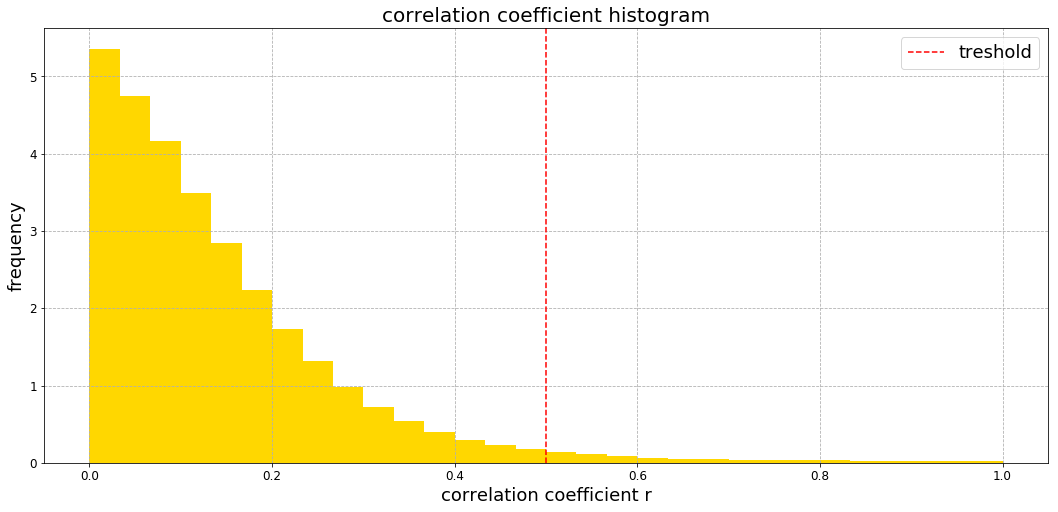

In [ ]:
fig, ax= plt.subplots(figsize=(18,8))

ax.axvline(THRESHOLD, c='r', label='treshold', ls='--')
ax.hist(correlations[np.isfinite(correlations)], bins=30, density=True, color='gold')


ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('correlation coefficient r', fontsize=18)
ax.set_ylabel('frequency', fontsize=18)
ax.set_title('correlation coefficient histogram', fontsize=20)
ax.grid(ls='--')
ax.legend(fontsize=18)
plt.show()

In [ ]:
# one thing to note is that the the correlation coefficients matrix has an higher number than expected considering
# the land nodes, in fact:

print('# of NaN correlation coefficient: ', np.sum(np.isnan(net.correlation())))


n_nan = n_grid_nan+len(zero_std_ind)
n_sea = n_grid_sea-len(zero_std_ind)
print('# of NaN expected from land nodes: ', n_nan*n_nan+2*n_nan*n_sea)

# of NaN correlation coefficient:  150158639
# of NaN expected from land nodes:  150158639


# Network Analysis

## Degree

In [ ]:
# average degree
adj_matrix = net.adjacency
k_array = net.degree()
L = np.sum(k_array)/2
avg_k = 2*L/n_sea
link_density = 2*L/(n_sea*(n_sea-1))
avg_path_lenght = 4.1357491702675375#net.average_path_length()

print('Average degree: {:.2f}'.format(avg_k))
print("Link density: {:.4f}".format(link_density))
print('L:', int(L))
print('Average path length: {:.2f}'.format(avg_path_lenght))

Average degree: 261.43
Link density: 0.0253
L: 1348866
Average path length: 4.14


In [ ]:
#  Save the degree sequence
np.savetxt("./centrality_measures/degree.txt", k_array)

In [ ]:
sea_k_array = k_array[not_zero_sea_indexes]

In [ ]:
sea_k_array

array([35, 35, 35, ..., 23, 22, 21])

In [ ]:
# i_fit = 4

k_min = 110
k_max = sea_k_array.max()

sea_k_array_filt = sea_k_array[(sea_k_array > k_min) ]#& (sea_k_array < k_max)]
gamma_an = 1 + 1/np.mean(np.log(sea_k_array_filt/k_min))
C = (gamma_an-1)*k_min**(gamma_an-1)


print('k_min considered: ', int(k_min))
print('k_max considered: ', int(k_max))
print('ML estimate for gamma: {:.3f}'.format(gamma_an))
print('C: {:.2f}'.format(C))

k_min considered:  143
k_max considered:  1395
ML estimate for gamma: 2.291
C: 784.01


In [ ]:
# LINEAR PLOT

from collections import Counter

k_counts = Counter(sea_k_array)
x, y = zip(*k_counts.items()) 

y = np.array(y)/len(sea_k_array)

mask = np.array(x)<k_min
x_not = np.array(x)[mask]
y_not = np.array(y)[mask]

fig, ax= plt.subplots(figsize=(7,7))

ax.scatter(x, y, s=25)
ax.scatter(x_not, y_not, s=25, color='white', edgecolors='C0', label='Saturation region')
ax.grid(ls='--')

ax.set_ylim(bottom=2e-5, top=4e-2)
#ax.set_xlim(left=1e-1, right=5e3)

ax.set_xlabel('k', fontsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$p_k$', fontsize=18)

ax.set_title('Degree distribution', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)

# plot line
x_fit =np.linspace(k_min, k_max ,1000)
ax.plot(x_fit, C*x_fit**(-gamma_an), label="fit: C$\cdot k^{\gamma}$", c='C1', lw=2)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=18, loc='upper left')


plt.tight_layout()
#plt.show()
plt.savefig('./degree.pdf', dpi=300, facecolor='white')


In [ ]:
# LOG-LOG BINNING
bins = np.logspace(np.log10(0.1), np.log10(k_max), 120)
hist, bin_edges = np.histogram(sea_k_array, bins=bins, density=True)
bin_x = bin_edges[:-1] + np.diff(bin_edges)/2

# LOG-LOG PLOT
y_log = hist
x_log = bin_x

mask = np.array(x_log)<k_min
x_not_log = np.array(x_log)[mask]
y_not_log = np.array(y_log)[mask]


fig, ax= plt.subplots(figsize=(7,7))

ax.scatter(x_log, y_log, s=25)
ax.scatter(x_not_log, y_not_log, s=25, color='white', edgecolors='C0', label='Saturation region')
ax.grid(ls='--')

ax.set_ylim(bottom=2e-5, top=4e-2)
ax.set_xlim(left=5e-1, right=3e3)

ax.set_xlabel('k', fontsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$p_k$', fontsize=18)

ax.set_title('Degree distribution (log-binning)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)

# plot line
x_fit =np.linspace(k_min, k_max ,1000)
ax.plot(x_fit, C*x_fit**(-gamma_an), label="fit: C$\cdot k^{\gamma}$", c='C1', lw=2)

#ax.vlines(x=k_min, ymin=1e-5, ymax=5e-3, colors='firebrick', label='$k_{min}$', linestyles='dashed')
ax.legend(fontsize=18, loc='upper left')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
#plt.show()
plt.savefig('./degree_logbinning.pdf', dpi=300, facecolor='white')

In [ ]:
# natural cutoff

k_max_nat = k_min*len(sea_k_array_filt)**(1/(gamma_an-1))
k_max_nat

123431.96656854804

In [ ]:
# structural cutoff

k_max_struct = (avg_k*n_grid_sea)**0.5
k_max_struct

1694.8837697392912

### Plot

In [ ]:
lat = ds_filtered.lat.values
lon = ds_filtered.lon.values

In [ ]:
# plot
lat2, lon2 = np.meshgrid(lat,lon)

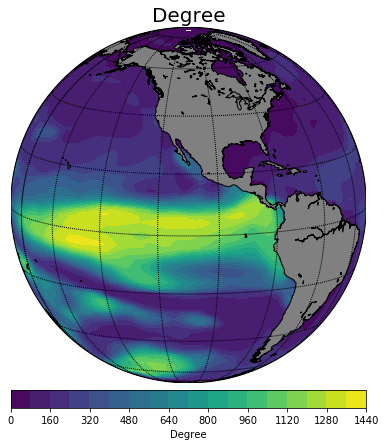

In [ ]:
# plot
lon2, lat2 = np.meshgrid(lon,lat)

m = Basemap(projection='ortho',lat_0=10,lon_0=250,resolution='l')
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(7,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))

cs = m.contourf(x,y,k_array.reshape((len(lat), len(lon))),20)

m.colorbar(location='bottom', label='Degree')


plt.title('Degree', fontsize=20)
plt.savefig('./images/degree_3D.pdf', dpi=300, facecolor='white')
#plt.show()

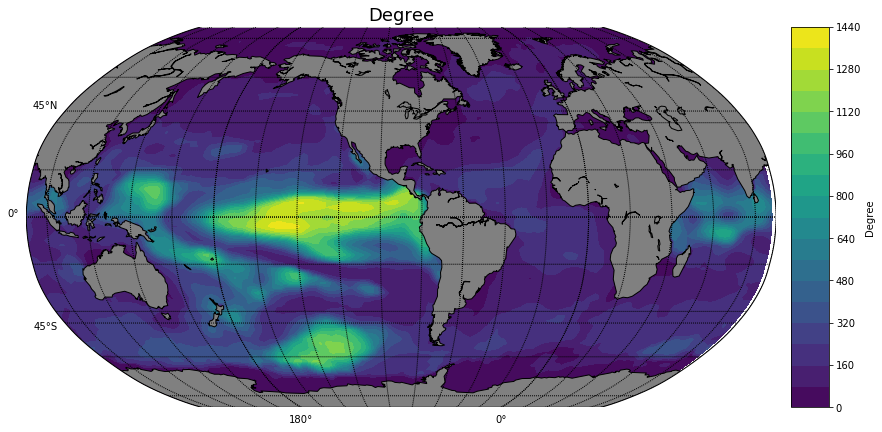

In [ ]:
data_matrix, lon_shift = shiftgrid(90, k_array.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
#m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20)#, cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Degree')

plt.title('Degree', fontsize=18)
plt.savefig('./images/degree_2D.pdf', dpi=300, facecolor='white')
#plt.show()

## Centrality

In [ ]:
# igraph network
ig_net = net.graph

In [ ]:
# read only
read_only = True

### PageRank

In [ ]:
eps = 0.00001
c = 0.85
n_iter = int(np.ceil((np.log(2/eps)+np.log(n_grid))/(np.log(1/c))))

In [ ]:
if not read_only: 
    pagerank = np.array(ig_net.pagerank(directed=False, damping=0.85, eps=eps,  niter=n_iter))
    # Save the PageRank sequence
    np.savetxt("./centrality_measures/PageRank.txt", pagerank)

In [ ]:
# Read the PageRank sequence
pagerank = np.loadtxt("./centrality_measures/PageRank.txt")
pagerank

array([1.34269039e-05, 1.34269039e-05, 1.34269039e-05, ...,
       1.34269039e-05, 1.34269039e-05, 1.34269039e-05])

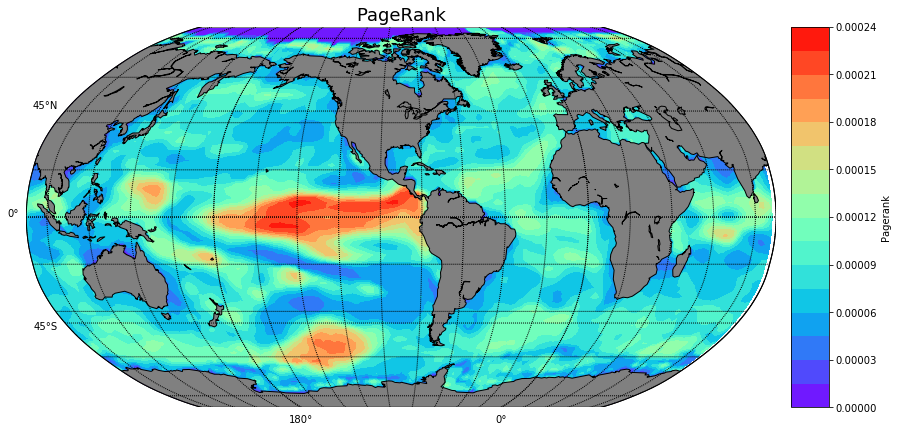

In [ ]:
data_matrix, lon_shift = shiftgrid(90, pagerank.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20, cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Pagerank')

plt.title('PageRank', fontsize=18)
plt.savefig('./images/pagerank.pdf', dpi=300, facecolor='white')

### Betweeness

In [ ]:
if not read_only: 
    betweenness = net.betweenness()
    
    # Save the betweeness sequence
    np.savetxt("./centrality_measures/betweenness.txt", betweenness)

In [ ]:
# Read the betweenness sequence
betweenness = np.loadtxt("./centrality_measures/betweenness.txt")
betweenness

array([0., 0., 0., ..., 0., 0., 0.])

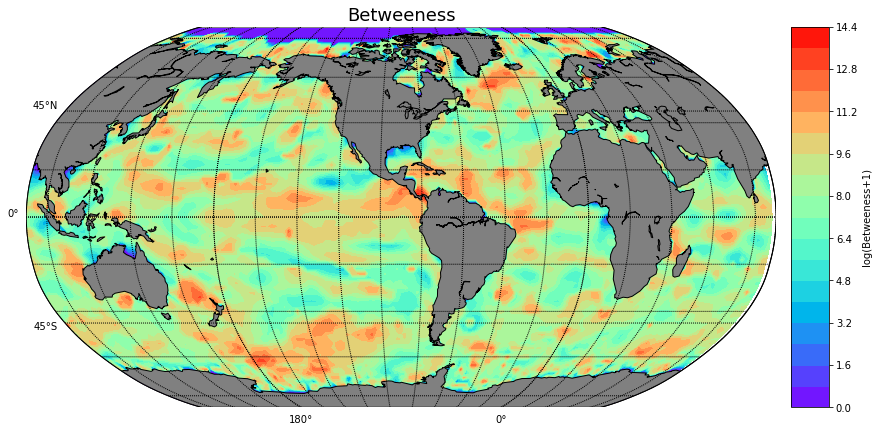

In [ ]:
data_matrix, lon_shift = shiftgrid(90, np.log(betweenness+1).reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.rainbow)
m.colorbar(location='right', label='log(Betweeness+1)')

plt.title('Betweeness', fontsize=18)
plt.savefig('./images/betweeness.pdf', dpi=300, facecolor='white')

### Harmonic closeness

In [ ]:
def harmonic_centrality(net):

    N = net.N
    harmonic_closeness = np.zeros(N)

    for i in range(N):

        di = np.array(net.graph.shortest_paths(i), dtype=float).flatten()          


        di[i] = np.inf
        harmonic_closeness[i] = (1.0/di).sum()
        
        if (i%1000 == 0):
            print('Number of points evaluated: ', i)

    return harmonic_closeness

In [ ]:
if not read_only: 
    harmonic_closeness = harmonic_centrality(net)

    # Save the harmonic_closeness sequence
    np.savetxt("./centrality_measures/harmonic_closeness.txt", harmonic_closeness)

In [ ]:
# Read the harmonic_closeness sequence
harmonic_closeness = np.loadtxt("./centrality_measures/harmonic_closeness.txt")
harmonic_closeness

array([0., 0., 0., ..., 0., 0., 0.])

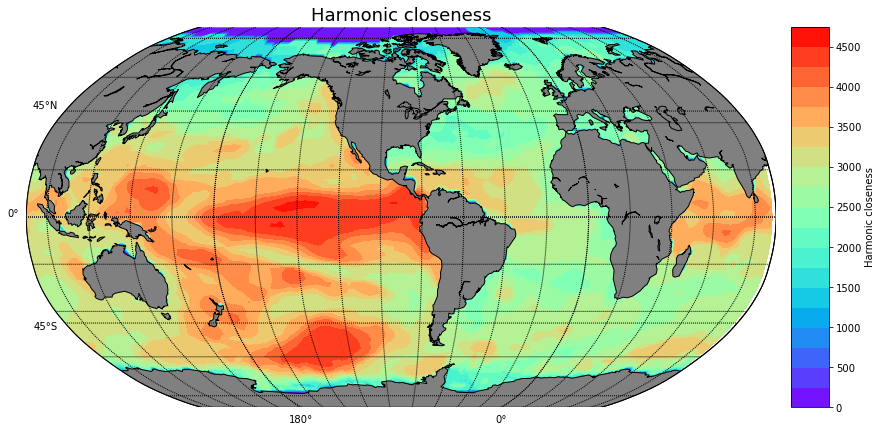

In [ ]:
data_matrix, lon_shift = shiftgrid(90, harmonic_closeness.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Harmonic closeness')

plt.title('Harmonic closeness', fontsize=18)
plt.savefig('./images/harmonic_closeness.pdf', dpi=300, facecolor='white')

### Closeness

In [ ]:
if not read_only:

    not_nan_closeness = not_nan_net.closeness()
    closeness = np.zeros(n_grid)
    closeness[non_zero_ind] = not_nan_closeness
    
    np.savetxt("./centrality_measures/closeness.txt", closeness)

In [ ]:
closeness = np.loadtxt("./centrality_measures/closeness.txt")

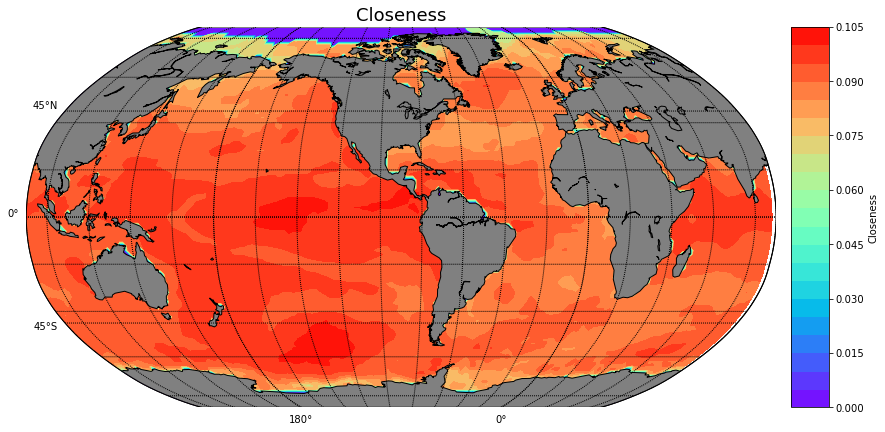

In [ ]:
data_matrix, lon_shift = shiftgrid(90, closeness.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20, cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Closeness')

plt.title('Closeness', fontsize=18)
plt.savefig('./images/closeness.pdf', dpi=300, facecolor='white')

### Eigenvector centrality

In [ ]:
if not read_only: 
    eigenvector_c = np.array(ig_net.eigenvector_centrality(directed=False))
    
    # Save the eigenvector_c sequence
    np.savetxt("./centrality_measures/eigenvector_c.txt", eigenvector_c)

In [ ]:
# Read the eigenvector_c sequence
eigenvector_c = np.loadtxt("./centrality_measures/eigenvector_c.txt")
eigenvector_c

array([0., 0., 0., ..., 0., 0., 0.])

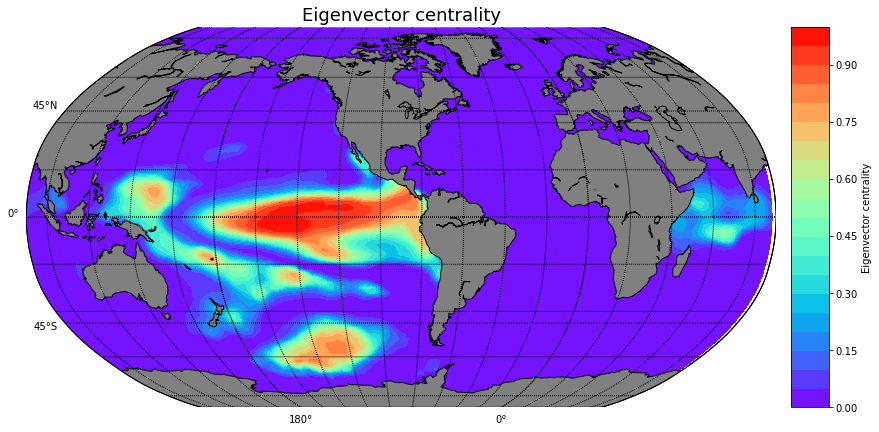

In [ ]:
data_matrix, lon_shift = shiftgrid(90, eigenvector_c.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Eigenvector centrality')

plt.title('Eigenvector centrality', fontsize=18)
plt.savefig('./images/eigenvector_c.pdf', dpi=300, facecolor='white')

### Clustering coefficient

In [ ]:
if not read_only: 
    clustering_coeff = np.array(ig_net.transitivity_local_undirected(mode='zero'))
    
    # Save the clustering_coeff sequence
    np.savetxt("./centrality_measures/clustering_coeff.txt", clustering_coeff)

In [ ]:
# Read the clustering_coeff sequence
clustering_coeff = np.loadtxt("./centrality_measures/clustering_coeff.txt")
clustering_coeff

array([0., 0., 0., ..., 0., 0., 0.])

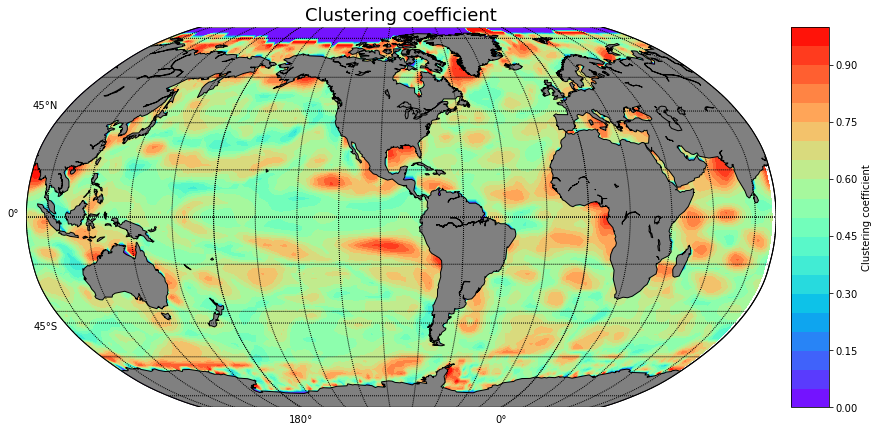

In [ ]:
data_matrix, lon_shift = shiftgrid(90, clustering_coeff.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.rainbow)
m.colorbar(location='right', label='Clustering coefficient')

plt.title('Clustering coefficient', fontsize=18)
plt.savefig('./images/clustering_coeff.pdf', dpi=300, facecolor='white')

## Geographical measures

### Area weighted connectivity

It gives the fractional area of the network, a node is connected to.

In [ ]:
if not read_only: 
    AWC = np.array(net.area_weighted_connectivity())
    
    # Save the AWC sequence
    np.savetxt("./centrality_measures/AWC.txt", AWC)

In [ ]:
# Read the AWC sequence
AWC = np.loadtxt("./centrality_measures/AWC.txt")
AWC

array([0., 0., 0., ..., 0., 0., 0.])

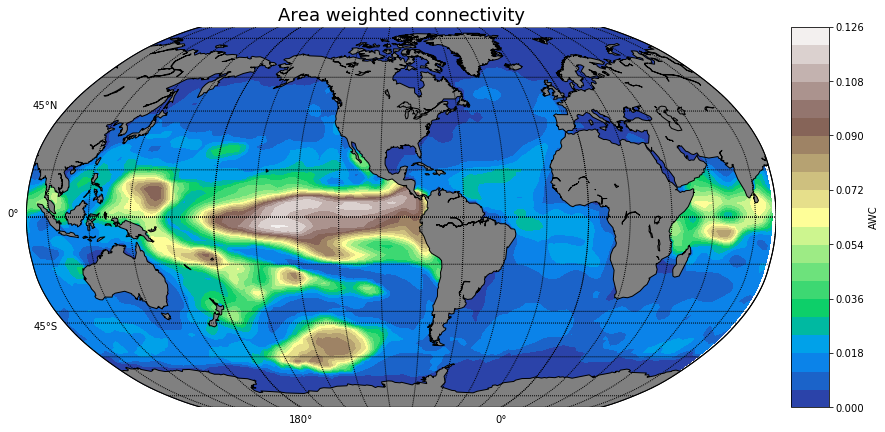

In [ ]:
data_matrix, lon_shift = shiftgrid(90, AWC.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.terrain)
m.colorbar(location='right', label='AWC')

plt.title('Area weighted connectivity', fontsize=18)
plt.savefig('./images/AWC.pdf', dpi=300, facecolor='white')

### Average link distance

In [ ]:
if not read_only: 
    ALD = np.array(net.average_link_distance())
    
    # Save the ALD sequence
    np.savetxt("./centrality_measures/ALD.txt", ALD)

In [ ]:
# Read the ALD sequence
ALD = np.loadtxt("./centrality_measures/ALD.txt")
ALD

array([0., 0., 0., ..., 0., 0., 0.])

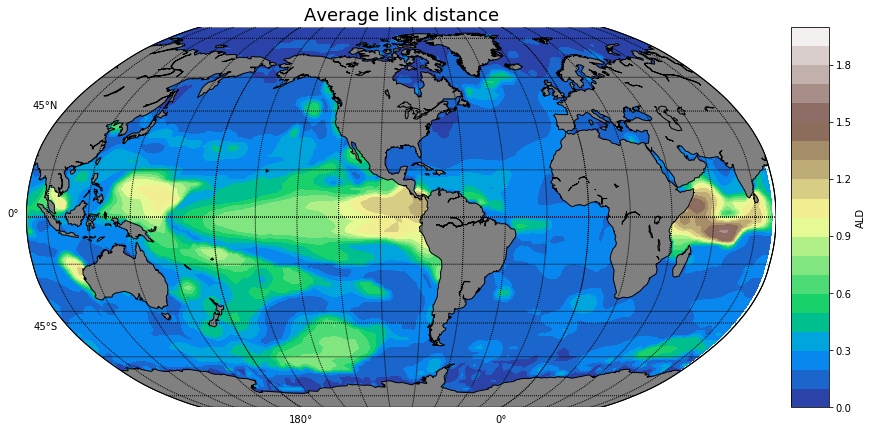

In [ ]:
data_matrix, lon_shift = shiftgrid(90, ALD.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.terrain)
m.colorbar(location='right', label='ALD')

plt.title('Average link distance', fontsize=18)
plt.savefig('./images/ALD.pdf', dpi=300, facecolor='white')

### Correlation distance weighted closeness

In [ ]:
if not read_only:

    not_nan_CDWC = not_nan_net.correlation_distance_weighted_closeness()
    CDWC = np.zeros(n_grid)
    CDWC[non_zero_ind] = not_nan_CDWC
    
    np.savetxt("./centrality_measures/CDWC.txt", CDWC)

In [ ]:
# Read the CDWC sequence
CDWC = np.loadtxt("./centrality_measures/CDWC.txt")
CDWC

array([0., 0., 0., ..., 0., 0., 0.])

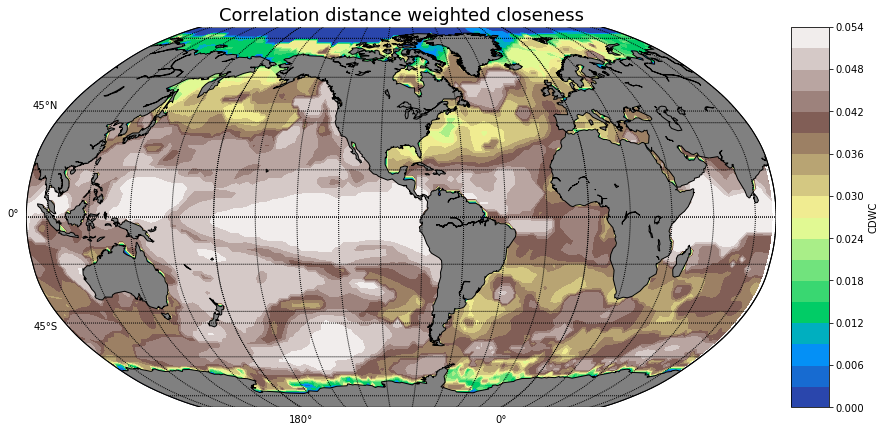

In [ ]:
data_matrix, lon_shift = shiftgrid(90, CDWC.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([45,0,-45],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])

cs = m.contourf(x,y,data_matrix,20,cmap=plt.cm.terrain)
m.colorbar(location='right', label='CDWC')

plt.title('Correlation distance weighted closeness', fontsize=18)
plt.savefig('./images/CDWC.pdf', dpi=300, facecolor='white')

### Link distance distribution

In [ ]:
link_distribution, stds, link_distances = net.link_distance_distribution(n_bins=80)

Calculating link distance distribution...
Calculating angular great circle distance using Cython...


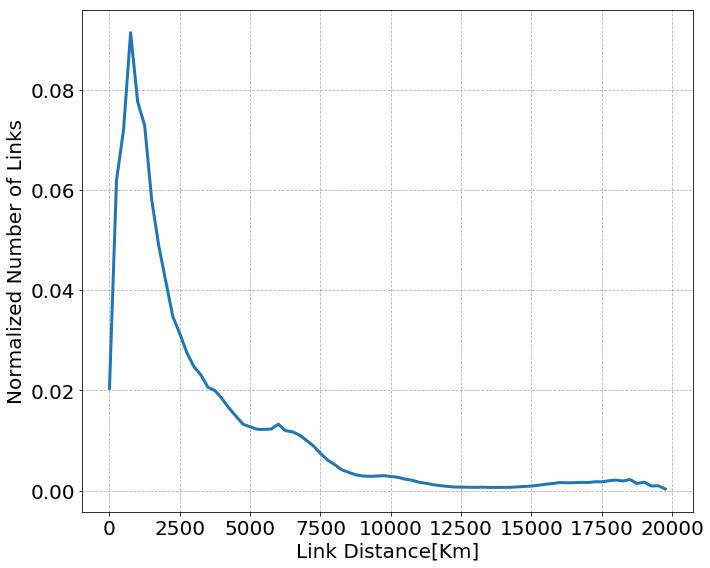

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(link_distances*6371, link_distribution, lw=3)

# ax.set_title('Link Distance Distribution', fontsize=25)
ax.set_xlabel('Link Distance[Km]', fontsize=20)
ax.set_ylabel('Normalized Number of Links', fontsize=20)


plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.grid(ls='--')

plt.tight_layout()
# plt.savefig('./link_distance_distribution.pdf', dpi=300, facecolor='white')

## Assortativity

### Degree correlation matrix

In [ ]:
# Degree correlation matrix

if not read_only: 

    edges_r, edges_c = np.where(adj_matrix==1)
    edges = np.array([edges_r, edges_c]).T
    k_edges = k_array[edges]

    k_edges_unique, k_edges_counts = np.unique(k_edges, axis=0, return_counts=True)
    k_edge_max = np.max(k_edges_unique)


    DCM_ind_r = (k_edges_unique-1)[:,0]
    DCM_ind_c = (k_edges_unique-1)[:,1]

    DCM = np.zeros((k_edge_max, k_edge_max))
    DCM[DCM_ind_r, DCM_ind_c] = k_edges_counts/np.sum(k_edges_counts)
    
    # Save the DCM sequence
    np.savetxt("./assortativity/DCM.txt", DCM)

In [ ]:
# Read the DCM matrix
DCM = np.loadtxt("./assortativity/DCM.txt")

In [ ]:
# log downsampling

n_ds = 200 # shape of downsampled matrix
log_ind = np.unique(np.geomspace(1,DCM.shape[0],n_ds, dtype='int'))

DCM_ds = np.zeros((len(log_ind), len(log_ind)))

for i in range(len(log_ind)-1):
    for j in range(len(log_ind)-1):
        DCM_ds[i,j] = np.sum(DCM[log_ind[i]:log_ind[i+1], log_ind[j]:log_ind[j+1]])

In [ ]:
DCM_ds[DCM_ds!=0] = np.log(DCM_ds[DCM_ds!=0])
DCM_ds[DCM_ds == 0] = -16

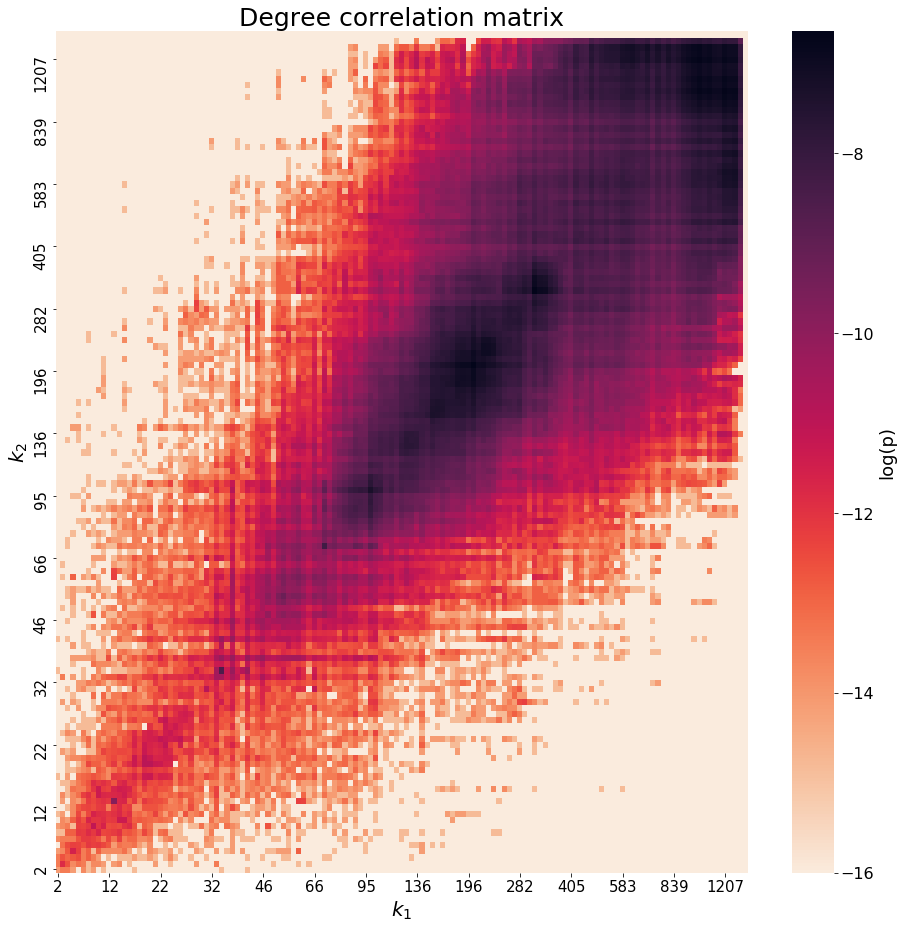

In [ ]:
# plot
fig, ax = plt.subplots(figsize = (13,13))

n_tick = 10
ax = sn.heatmap(DCM_ds,
                cmap = "rocket_r",#'Blues',#
                xticklabels = n_tick,
                yticklabels = n_tick,
                )

labels = ['{:.0f}'.format(x) for x in log_ind[::n_tick]+1]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.collections[0].colorbar.ax.tick_params(labelsize = 16)
ax.collections[0].colorbar.set_label('log(p)', fontsize=18)
ax.invert_yaxis()
ax.set_title('Degree correlation matrix', fontsize=25)
ax.set_xlabel('$k_1$', fontsize=20)
ax.set_ylabel('$k_2$', fontsize=20)

plt.tight_layout()
plt.savefig('./images/Degree_corr_matrix_log.pdf', dpi=300, facecolor='white')

In [ ]:
# linear downsampling

n_ds = 103 # shape of downsampled matrix
DCM_ds = np.zeros((n_ds,n_ds))

r = DCM.shape[0]//n_ds

for i in range(n_ds):
    for j in range(n_ds):
        DCM_ds[i,j] = np.sum(DCM[i*r:i*r+r, j*r:j*r+r])

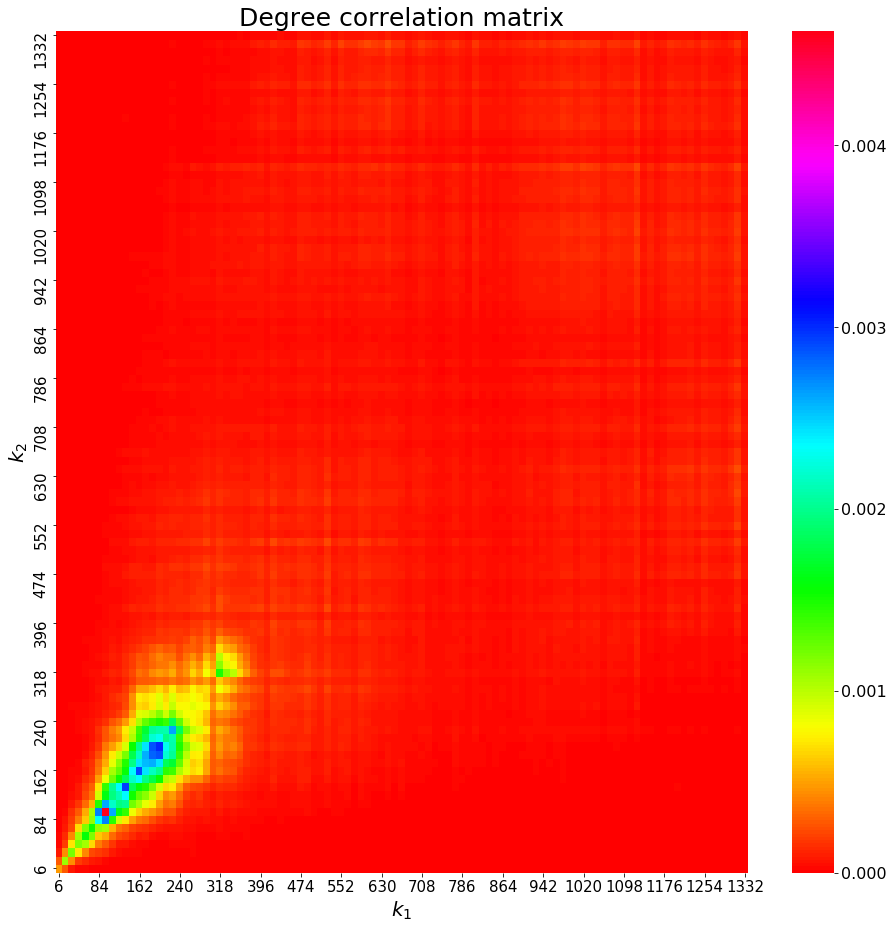

In [ ]:
# plot
fig, ax = plt.subplots(figsize = (13,13))
ax = sn.heatmap(DCM_ds,
                cmap = "hsv",
                xticklabels = 6,
                yticklabels = 6,
                )

labels = ['{:.0f}'.format(x*r) for x in ax.get_xticks()]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.collections[0].colorbar.ax.tick_params(labelsize = 16)
ax.invert_yaxis()
ax.set_title('Degree correlation matrix', fontsize=25)
ax.set_xlabel('$k_1$', fontsize=20)
ax.set_ylabel('$k_2$', fontsize=20)

plt.tight_layout()
#plt.savefig('./images/Degree_corr_matrix.pdf', dpi=300, facecolor='white')

### NNdegree

In [ ]:
# random rewiring
sea_k_array = k_array[sea_indexes]
degree_sequence = sea_k_array[sea_k_array!=0].tolist()
n_iterations = 100
knn_random_avg = 0

if not read_only:
    random.seed(1234)
    for i in range(n_iterations):
        print(i)
        g = ig.GraphBase.Degree_Sequence(degree_sequence, method="vl")
        _, avg_knn = g.knn()
        knn_random_avg += np.array(avg_knn)

        np.save('./assortativity/random_avg_knn_vl.npy', knn_random_avg/(i+1))

        del g
        gc.collect()
        

In [ ]:
#two lists in a tuple. The first list contains the average degree of neighbors for each vertex, 
# the second contains the average degree of neighbors as a function of vertex degree. 

_, avg_knn = ig_net.knn()

In [ ]:
log_knn = np.log(avg_knn[1:])
log_k = np.log(np.arange(1,len(avg_knn)))

log_k = log_k[~np.isnan(log_knn)]
log_knn = log_knn[~np.isnan(log_knn)]

model = LinearRegression().fit(log_k.reshape(-1,1), log_knn)

mu = model.coef_[0]
B = model.intercept_

fit = pow(np.arange(1,len(avg_knn)), mu)

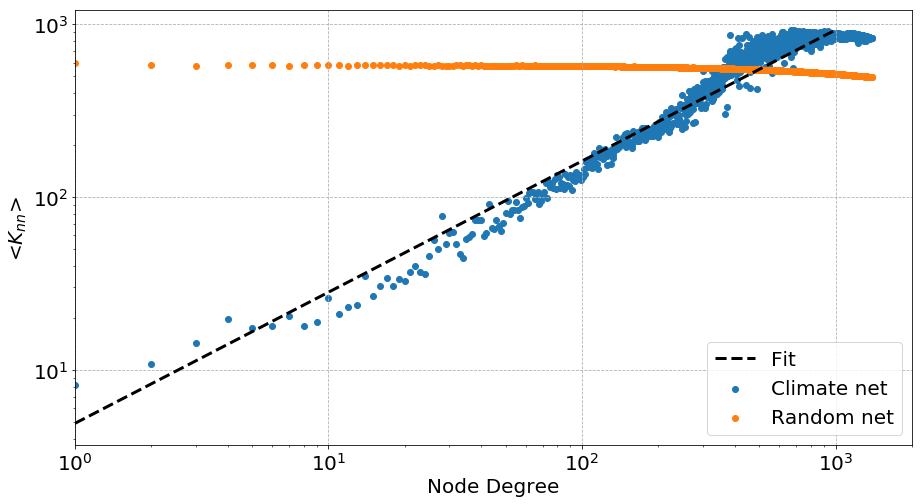

In [ ]:
# import random rewired networks plot
rand_net_knn = np.load('./assortativity/random_avg_knn_vl.npy')

x_fit = np.arange(1,1000)
y_fit = np.exp(B)*np.power(x_fit, mu)


# plot
fig, ax= plt.subplots(figsize=(15,8))

ax.scatter(np.arange(len(avg_knn)),avg_knn, label='Climate net')
ax.scatter(np.arange(len(avg_knn)),rand_net_knn, label='Random net')
ax.plot(x_fit, y_fit, color='black', lw=3, linestyle='--', label='Fit')


ax.set_xlabel('Node Degree', fontsize=20)
ax.set_ylabel('<$K_{nn}$>', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,2000)
ax.tick_params(axis='both', which='major', labelsize=12)


# ax.set_title('KNN vs Degree', fontsize=20)
ax.grid(ls='--')
ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.savefig('./images/knn_vs_degree.pdf', dpi=300, facecolor='white')
plt.show()

## Community detection

In [ ]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
if not read_only:
# adj_matrix for just sea points

    sea_adj_matrix = np.delete(adj_matrix, nan_indexes, axis=0) # +list(zero_std_ind)
    sea_adj_matrix = np.delete(sea_adj_matrix, nan_indexes, axis=1)
    
    #  Save the sea_adj_matrix sequence
    np.save("./community_detection/sea_adj_matrix_thresh_"+str(THRESHOLD)+'-1980.2000.NOAA'+'.npy', sea_adj_matrix)

In [ ]:
# Read the sea_adj_matrix 
sea_adj_matrix = np.load("./community_detection/sea_adj_matrix_thresh_"+str(THRESHOLD)+'-1980.2000.NOAA'+'.npy')

In [ ]:
# networkx graph
sea_nx_net = nx.from_numpy_matrix(sea_adj_matrix)

### Louvain algorithm

In [ ]:
resolution = 0.6
threshold = 1e-7

file_name = "./community_detection/louv_com_list_" + str(resolution) + '_' + str(threshold) + 'NOAA1980'

In [ ]:
with open(file_name, "rb") as fp:   # Unpickling
    louv_com_list = pickle.load(fp)

#louv_com_list

In [ ]:
com_dict = {}
com_abbundance = {}

for i in range(0,len(louv_com_list)):
    # converting the element of the list in list
    louv_com_list[i] = list(louv_com_list[i])

    #saving the indexes of the communities
    com_dict[i+1] = sea_indexes[louv_com_list[i]]
    com_abbundance[i+1] = len(louv_com_list[i])

In [ ]:
community_values = np.zeros_like(data.observable().data[0])

In [ ]:
count = 1
for key, indexes_list in com_dict.items():
    if com_abbundance[key] > 100:
        community_values[indexes_list] = count
        count += 1

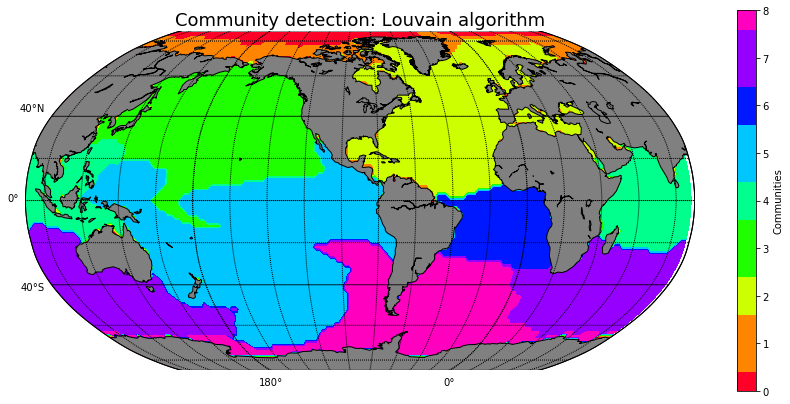

In [ ]:
data_matrix, lon_shift = shiftgrid(90, community_values.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([40,0,-40],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])


#cmap = plt.get_cmap('RdBu', count-1)

cs = m.contourf(x,y,data_matrix,20,cmap=discrete_cmap(count, 'gist_rainbow'))


plt.colorbar(ticks=range(count), label='Communities')
plt.clim(-0.5, count - 0.5)

plt.title('Community detection: Louvain algorithm', fontsize=18)
plt.savefig('./images/Louvain.pdf', dpi=300, facecolor='white')

In [ ]:
cluster_zero_list = []
mod_list = []

for i in range(len(louv_com_list)):
    if len(louv_com_list[i]) < 100:
        cluster_zero_list += louv_com_list[i]
    else:
        mod_list.append(louv_com_list[i])
        

mod_list.append(cluster_zero_list)

In [ ]:
modularity = community.modularity(sea_nx_net, mod_list)

In [ ]:
print('Modularity: {:.5f}'.format(modularity))

Modularity: 0.57311


In [ ]:
def conductance(sea_nx_net = sea_nx_net, mod_list = mod_list, sea_adj_matrix = sea_adj_matrix):
    cond = 0
    for i in range(len(mod_list)):
        cut_i = nx.conductance(sea_nx_net, mod_list[i])
        assoc_i = np.sum(sea_adj_matrix[mod_list[i], :])
        cond += cut_i/assoc_i
    return cond

In [ ]:
conductance_louv = conductance()

In [ ]:
print('Conductance: {:.6f}'.format(conductance_louv))

Conductance: 0.000498


### Consensus clustering

In [ ]:
file_name = "./community_detection/cons_com_list_10_step"

In [ ]:
with open(file_name, "rb") as fp:   # Unpickling
    cons_com_list = pickle.load(fp)

In [ ]:
com_dict = {}
com_abbundance = {}

for i in range(0,len(cons_com_list)):

    #saving the indexes of the communities
    com_dict[i+1] = sea_indexes[cons_com_list[i]]
    com_abbundance[i+1] = len(cons_com_list[i])

In [ ]:
community_values = np.zeros_like(data.observable().data[0])

In [ ]:
count = 1
for key, indexes_list in com_dict.items():
    if com_abbundance[key] > 100:
        community_values[indexes_list] = count
        count += 1

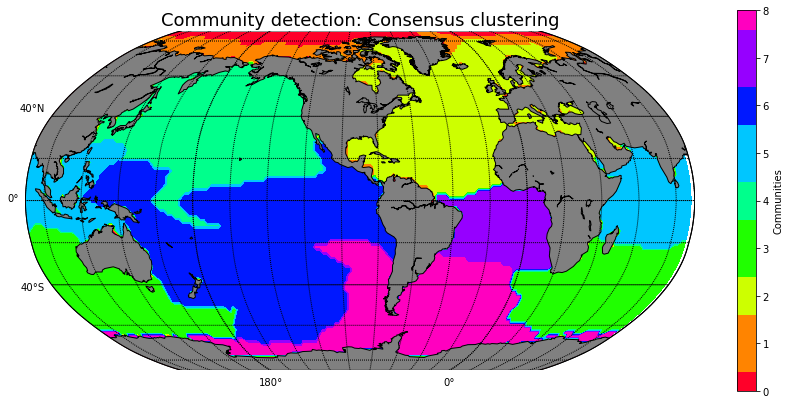

In [ ]:
data_matrix, lon_shift = shiftgrid(90, community_values.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([40,0,-40],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])


#cmap = plt.get_cmap('RdBu', count-1)

cs = m.contourf(x,y,data_matrix,20,cmap=discrete_cmap(count, 'gist_rainbow'))


plt.colorbar(ticks=range(count), label='Communities')
plt.clim(-0.5, count - 0.5)

plt.title('Community detection: Consensus clustering', fontsize=18)
plt.savefig('./images/consensus_clustering.pdf', dpi=300, facecolor='white')

In [ ]:
cluster_zero_list = []
mod_list = []

for i in range(len(cons_com_list)):
    if len(cons_com_list[i]) < 100:
        cluster_zero_list += cons_com_list[i]
    else:
        mod_list.append(cons_com_list[i])
        

mod_list.append(cluster_zero_list)

In [ ]:
enso_indexes = mod_list[2]

In [ ]:
modularity = community.modularity(sea_nx_net, mod_list)

In [ ]:
print('Modularity: {:.5f}'.format(modularity))

Modularity: 0.57298


In [ ]:
conductance_cons = conductance()

In [ ]:
print('Conductance: {:.7f}'.format(conductance_cons))

Conductance: 0.0004984


### Spectral clustering

In [ ]:
file_name = "./community_detection/spec_clust" + 'NOAA1980' 

In [ ]:
with open(file_name, "rb") as fp:   # Unpickling
    spec_com_list = pickle.load(fp)

com_dict = {}
com_abbundance = {}

for i in range(0,len(spec_com_list)):
    # converting the element of the list in list
    spec_com_list[i] = list(spec_com_list[i])

    #saving the indexes of the communities
    com_dict[i+1] = sea_indexes[spec_com_list[i]]
    com_abbundance[i+1] = len(spec_com_list[i])

In [ ]:
community_values = np.zeros_like(data.observable().data[0])

In [ ]:
count = 1
for key, indexes_list in com_dict.items():
    if com_abbundance[key] > 200:
        community_values[indexes_list] = count
        count += 1

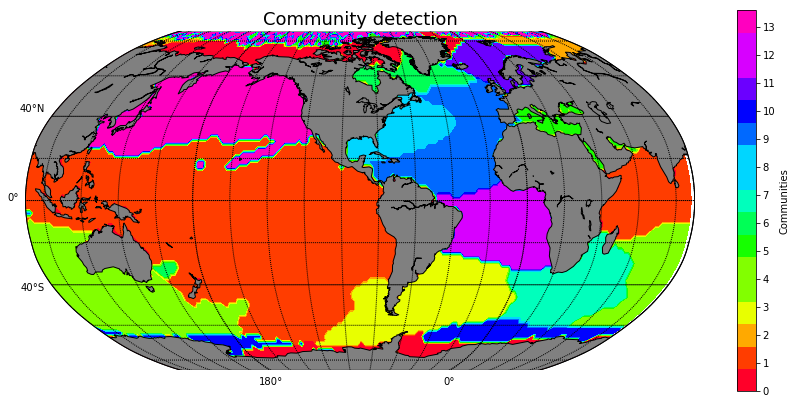

In [ ]:
data_matrix, lon_shift = shiftgrid(90, community_values.reshape((len(lat), len(lon))), lon, start=False)
lon2, lat2 = np.meshgrid(lon_shift, lat)

m = Basemap(projection='robin', lat_0=0, lon_0=-90)
x, y = m(lon2, lat2)

fig = plt.figure(figsize=(15,7))
m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(0.,360.,20.))
m.drawmapboundary(fill_color='white')
m.drawparallels([40,0,-40],labels=[1,0,0,0])
m.drawmeridians([0,90,180],labels=[0,0,0,1])


#cmap = plt.get_cmap('RdBu', count-1)

cs = m.contourf(x,y,data_matrix,20,cmap=discrete_cmap(count, 'gist_rainbow'))


plt.colorbar(ticks=range(count), label='Communities')
plt.clim(-0.5, count - 0.5)

plt.title('Community detection', fontsize=18)
plt.savefig('./images/spectral_clustering.pdf', dpi=300, facecolor='white')

In [ ]:
cluster_zero_list = []
mod_list = []

for i in range(len(spec_com_list)):
    if len(spec_com_list[i]) < 100:
        cluster_zero_list += spec_com_list[i]
    else:
        mod_list.append(spec_com_list[i])
        
if len(cluster_zero_list) > 0:
    mod_list.append(cluster_zero_list)

In [ ]:
modularity = community.modularity(sea_nx_net, mod_list)

In [ ]:
print('Modularity: {:.3f}'.format(modularity))

Modularity: 0.468


In [ ]:
conductance_spec = conductance()

In [ ]:
print('Conductance: {:.7f}'.format(conductance_spec))

Conductance: 0.0004984


## Robustness

### Giant Component fraction

In [ ]:
# Giant component fraction removing ENSO community

def GC_community_attack(sea_adj_matrix = sea_adj_matrix, enso_indexes = enso_indexes, iterations=41):

    # complementary community
    not_enso_indexes = [i for i in range(len(sea_adj_matrix)) if i not in enso_indexes]
    
    # shuffling
    np.random.shuffle(enso_indexes)
    np.random.shuffle(not_enso_indexes)
    
    # networkx net
    nx_net = nx.from_numpy_matrix(sea_adj_matrix)
    GC_size_initial = len(max(nx.connected_component_subgraphs(nx_net), key=len))

    f = 1/iterations
    GC_fraction = np.zeros(iterations+1)
    GC_fraction[0] = 1
    n_rem_node = int(f*len(sea_adj_matrix))
    
    sea_A_under_removal = sea_adj_matrix

    remo_ind_list = []

    for i in range(iterations):
        
        print(i)
        
                
        if len(enso_indexes) > n_rem_node:
            remo_ind = enso_indexes[:n_rem_node]
            enso_indexes = enso_indexes[n_rem_node:]
            
            
        elif len(enso_indexes) != 0:            
            n_diff = n_rem_node-len(enso_indexes)
            remo_ind = enso_indexes
            
            
            remo_ind += not_enso_indexes[:n_diff]
            not_enso_indexes = not_enso_indexes[n_diff:]
            enso_indexes = []
            
        else:
            remo_ind = not_enso_indexes[:n_rem_node]
            not_enso_indexes = not_enso_indexes[n_rem_node:]
            
            if len(not_enso_indexes)<n_rem_node:
                remo_ind += not_enso_indexes[:]
                not_enso_indexes = []
            
            

        remo_ind_list += remo_ind

        sea_A_under_removal = np.delete(sea_adj_matrix, remo_ind_list, axis=0)
        sea_A_under_removal = np.delete(sea_A_under_removal, remo_ind_list, axis=1)
        
        
        # networkx graph
        nx_net = nx.from_numpy_matrix(sea_A_under_removal)        
        
        if i != iterations-1:
            GC_fraction[i+1] = len(max(nx.connected_component_subgraphs(nx_net), key=len))/GC_size_initial
        else:
            GC_fraction[i+1] = 0
        
        
    #  Save the GC_fraction sequence
    np.savetxt("GC_fraction_enso.txt", GC_fraction)

In [ ]:
#GC_community_attack(sea_adj_matrix = sea_adj_matrix, enso_indexes = enso_indexes, iterations=100)

In [ ]:
# Giant component fraction removing random nodes
def GC_random(sea_adj_matrix = sea_adj_matrix, iterations=41):

    nx_net = nx.from_numpy_matrix(sea_adj_matrix)
    GC_size_initial = len(max(nx.connected_component_subgraphs(nx_net), key=len))
    

    f = 1/iterations
    GC_fraction = np.zeros(iterations+1)
    GC_fraction[0] = 1
    n_rem_node = int(f*len(sea_adj_matrix))
    
    sea_A_under_removal = sea_adj_matrix

    indexes = list(range(len(sea_adj_matrix)))
    np.random.shuffle(indexes)
    remo_ind_list = []

    for i in range(iterations):
        
        print(i)
        
        remo_ind = indexes[:n_rem_node]
        indexes = indexes[n_rem_node:]

        if len(indexes)<n_rem_node:
            remo_ind += indexes[:]
            indexes = []
            
            

        remo_ind_list += remo_ind

        sea_A_under_removal = np.delete(sea_adj_matrix, remo_ind_list, axis=0)
        sea_A_under_removal = np.delete(sea_A_under_removal, remo_ind_list, axis=1)
        
        
        # networkx graph
        nx_net = nx.from_numpy_matrix(sea_A_under_removal)        
        
        if i != iterations-1:
            GC_fraction[i+1] = len(max(nx.connected_component_subgraphs(nx_net), key=len))/GC_size_initial
        else:
            GC_fraction[i+1] = 0
        
        
    #  Save the GC_fraction sequence
    np.savetxt("GC_fraction.txt", GC_fraction)

In [ ]:
#GC_random(sea_adj_matrix = sea_adj_matrix, iterations=100)

In [ ]:
# Giant component fraction removing sorted nodes

def GC_attack(sea_adj_matrix = sea_adj_matrix, iterations=41):

    nx_net = nx.from_numpy_matrix(sea_adj_matrix)
    GC_size_initial = len(max(nx.connected_component_subgraphs(nx_net), key=len))

    f = 1/iterations
    GC_fraction = np.zeros(iterations+1)
    GC_fraction[0] = 1
    n_rem_node = int(f*len(sea_adj_matrix))
    
    sea_A_under_removal = sea_adj_matrix

    sort_indexes = list(np.argsort(list(dict(nx_net.degree()).values()))[::-1])
    remo_ind_list = []

    for i in range(iterations):
        
        print(i)
        
        remo_ind = sort_indexes[:n_rem_node]
        sort_indexes = sort_indexes[n_rem_node:]

        if len(sort_indexes)<n_rem_node:
            remo_ind += sort_indexes[:]
            sort_indexes = []
            
            

        remo_ind_list += remo_ind

        sea_A_under_removal = np.delete(sea_adj_matrix, remo_ind_list, axis=0)
        sea_A_under_removal = np.delete(sea_A_under_removal, remo_ind_list, axis=1)
        
        
        # networkx graph
        nx_net = nx.from_numpy_matrix(sea_A_under_removal)        
        
        if i != iterations-1:
            GC_fraction[i+1] = len(max(nx.connected_component_subgraphs(nx_net), key=len))/GC_size_initial
        else:
            GC_fraction[i+1] = 0
        
        
    #  Save the GC_fraction sequence
    np.savetxt("GC_fraction_attack.txt", GC_fraction)

In [ ]:
#GC_attack(sea_adj_matrix = sea_adj_matrix, iterations=100)

In [ ]:
# Read the GC_fraction matrix
GC_fraction = np.loadtxt("./robustness/GC_fraction.txt")
GC_fraction_enso = np.loadtxt("./robustness/GC_fraction_enso.txt")
GC_fraction_attack = np.loadtxt("./robustness/GC_fraction_attack.txt")

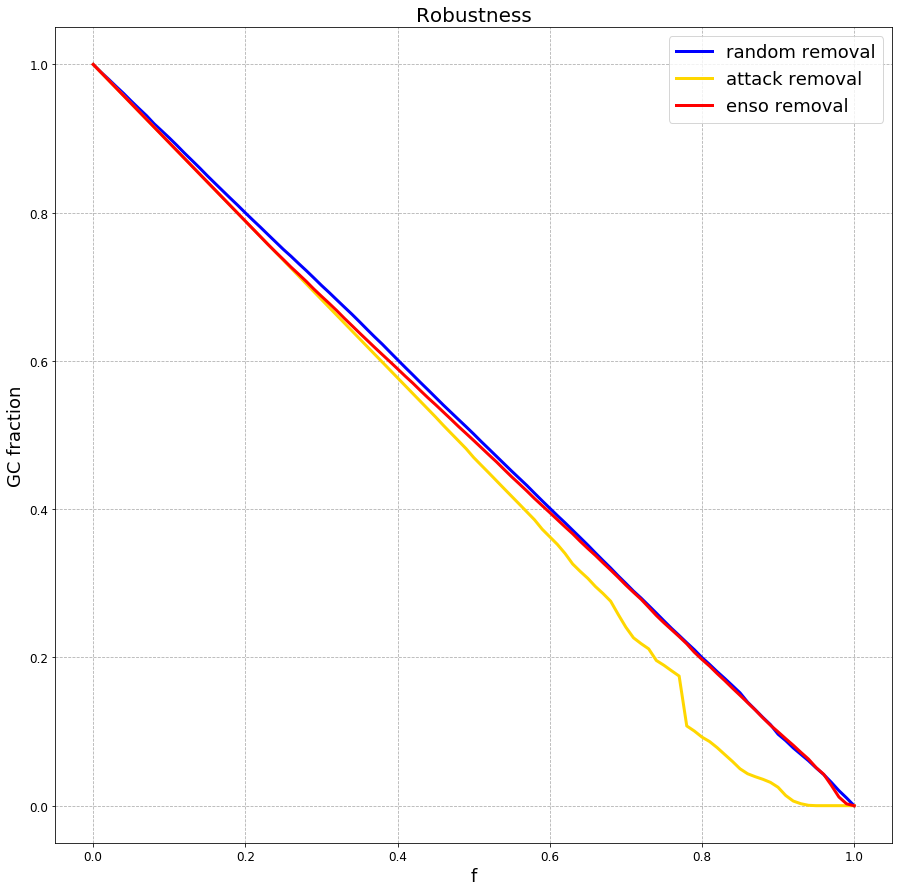

In [ ]:
fig, ax= plt.subplots(figsize=(15,15))

f = np.linspace(0,1,len(GC_fraction))
ax.plot(f, GC_fraction, '-', c='b', lw=3, label='random removal')

f = np.linspace(0,1,len(GC_fraction_attack))
ax.plot(f, GC_fraction_attack, '-', c='gold', lw=3, label='attack removal')

f = np.linspace(0,1,len(GC_fraction_enso))
ax.plot(f, GC_fraction_enso, '-', c='r', lw=3, label='enso removal')



ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('f', fontsize=18)
ax.set_ylabel('GC fraction', fontsize=18)
ax.set_title('Robustness', fontsize=20)
ax.grid(ls='--')
#ax.set_box_aspect(1)
ax.legend(fontsize=18)
plt.savefig('./images/GC_fraction.pdf', dpi=300, facecolor='white')

In [ ]:
# evaluation of f_c

f_c = 1-1/((gamma_an-2)/(3-gamma_an)*k_min**(gamma_an-2)*k_max_struct**(3-gamma_an)-1)

In [ ]:
print('The braking point is f_c = {:.4f}'.format(f_c))

The braking point is f_c = 0.9970


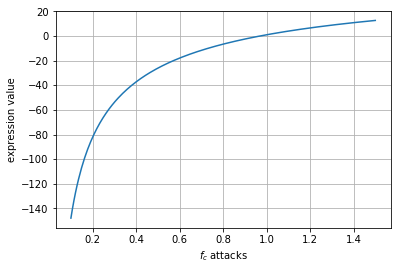

In [ ]:
func = lambda fc : 2 + (2-gamma_an)/(3-gamma_an)*k_min*(fc**((3-gamma_an)/(1-gamma_an))-1) -fc**((2-gamma_an)/(1-gamma_an))  

tau = np.linspace(0.1, 1.5, 201)

plt.plot(tau, func(tau))
plt.xlabel("$f_c$ attacks")
plt.ylabel("expression value")
plt.grid()
plt.show()

In [ ]:
tau_initial_guess = 0.5
tau_solution = fsolve(func, tau_initial_guess)

print("The solution is f_c = %f" % tau_solution)
print("at which the value of the expression is %f" % func(tau_solution))

The solution is f_c = 0.969534
at which the value of the expression is -0.000000
